<a href="https://colab.research.google.com/github/smok313-zdr/FindMyOrder/blob/main/FindMyOrder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import danych treningowych z github

Fragment kodu kopiujący strukturę katalogu baretki z github, w którym będą przechowywane obrazy do trenowania modelu. Miejsce, w którym zostanie utworzona struktura nowego katalogu definiowana jest w zmiennej `root_directory`.

In [1]:
import os
import subprocess
import shutil

def create_and_populate_directory(root_dir, github_url, target_folder):
    """Tworzy strukturę katalogów dla zbioru danych 'baretki' i
    wypełnia ją danymi z GitHub za pomocą git clone.

    Args:
        root_dir: Katalog główny, w którym zostanie utworzona struktura.
        github_url: Adres URL repozytorium GitHub zawierającego dane.
        target_folder: Konkretny folder do sklonowania z repozytorium.
    """

    # Tymczasowy katalog do sklonowania repozytorium
    temp_dir = os.path.join(root_dir, "temp_repo")
    # Upewnij się, że tymczasowy katalog jest pusty przed klonowaniem
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir, exist_ok=True)

    # Użyj sparse checkout, aby sklonować tylko folder docelowy
    subprocess.run(['git', 'clone', '--depth=1', '--filter=blob:none', '--sparse', github_url, temp_dir], check=True)
    subprocess.run(['git', '-C', temp_dir, 'sparse-checkout', 'set', target_folder], check=True)

    # Przenieś folder docelowy do katalogu głównego
    target_dir = os.path.join(root_dir, target_folder)

    # Sprawdź, czy katalog docelowy już istnieje
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    shutil.move(os.path.join(temp_dir, target_folder), target_dir)

    # Usuń katalog tymczasowy
    shutil.rmtree(temp_dir)

    # Usuń niepotrzebne pliki i katalogi
    for item in [".git", "FindMyOrder.ipynb", "README.md"]:
        item_path = os.path.join(root_dir, item)
        if os.path.exists(item_path):
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            else:
                os.remove(item_path)

# Zdefiniuj katalog główny, adres URL GitHub i folder docelowy
root_directory = "/content/"
github_url = "https://github.com/smok313-zdr/FindMyOrder.git"
target_folder = "baretki"

# Wywołaj funkcję, aby utworzyć i wypełnić katalog
create_and_populate_directory(root_directory, github_url, target_folder)

print(f"Struktura katalogów utworzona i wypełniona danymi z GitHub w: {root_directory+target_folder}")

Struktura katalogów utworzona i wypełniona danymi z GitHub w: /content/baretki


# Budowa modelu sztucznej sieci neuronowej

W tym fragmencie kodu budowana jest Konwolucyjna Sieć Neuronowa (CNN), która jest przystosowana do klasyfikacji obrazów. Sieć składa się z 11 warstw `keras.layers`.  

*   `Input` - Warstwa wejściowa. Definiuje kształt danych wejściowych, które będą dostarczane do modelu. W tym przypadku oczekuje obrazów o szerokości `img_width`, wysokości `img_height` i 3 kanałach kolorów (RGB).
*   `keras.layers.Conv2D` - Warstwa konwolucyjna. Działa jako ekstraktor cech. Uczy się określonej liczby różnych filtrów (jąder), które są stosowane na obrazie wejściowym w celu wykrycia wzorców, takich jak krawędzie, narożniki i tekstury. Aktywacja relu wprowadza nieliniowość, umożliwiając modelowi uczenie się bardziej złożonych relacji.
*   `keras.layers.MaxPooling2D` - Warstwa poolingu. Obniża próbkowanie danych wyjściowych poprzedniej warstwy konwolucyjnej, pobierając maksymalną wartość w każdym oknie 2x2. Zmniejsza to wymiary przestrzenne, dzięki czemu model jest bardziej odporny na niewielkie zmiany danych wejściowych i zmniejsza obciążenie obliczeniowe.

*   `keras.layers.Flatten` - Warstwa spłaszczająca. Przekształca wielowymiarowe dane wyjściowe warstw konwolucyjnych w pojedynczy, długi wektor. Jest to niezbędne do przekazywania danych do kolejnych w pełni połączonych warstw, które oczekują jednowymiarowych danych wejściowych.

*   `keras.layers.Dense` - Warstwa gestości. Wykonuje dalsze przetwarzanie spłaszczonych cech, ucząc się złożonych relacji między nimi.

*   `keras.layers.Dropout` - Warstwa dropout. Pomaga zapobiegać nadmiernemu dopasowaniu, losowo ustawiając 50% jednostek wejściowych na 0 podczas uczenia. Zmusza to model do uczenia się bardziej niezawodnych funkcji i zmniejsza jego zależność od pojedynczego neuronu.

Visible directories: ['/content/baretki/Medal za długoletnią służbę - brązowa', '/content/baretki/Siły Zbrojne w Służbie Ojczyzny - brązowa', '/content/baretki/Medal za długoletnią służbę - srebrna', '/content/baretki/Siły Zbrojne w Służbie Ojczyzny - srebrna', '/content/baretki/Medal za długoletnią służbę - złota', '/content/baretki/Siły Zbrojne w Służbie Ojczyzny - złota']
Found 50 images belonging to 6 classes.
Found 12 images belonging to 6 classes.


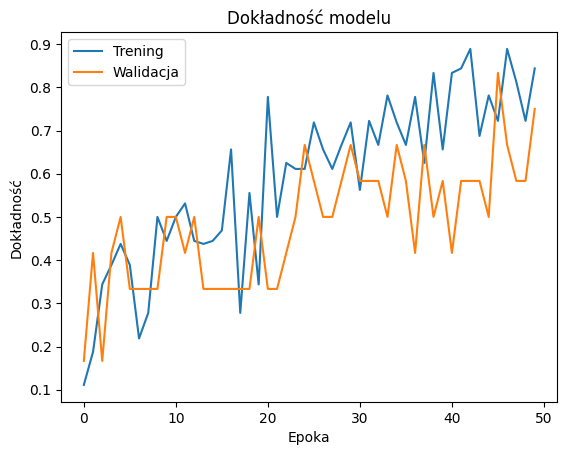

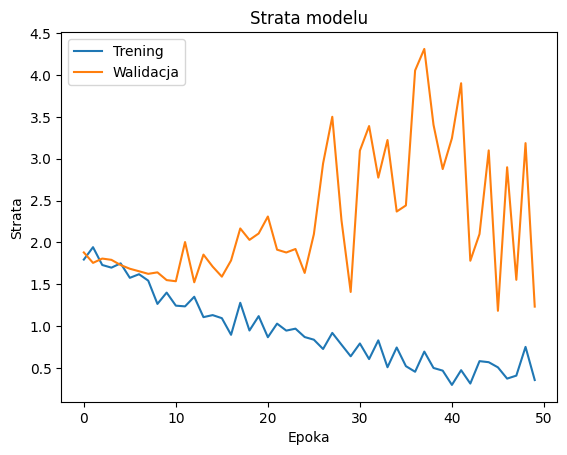

In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Ścieżka do folderów z danymi
data_dir = "/content/baretki"

# Parametry modelu
img_width, img_height = 150, 150
batch_size = 32
epochs = 50  # Zwiększ liczbę epok dla lepszej jakości predykcji

# Generatory danych
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% danych do walidacji
)

# Pomijanie ukrytych folderów i plików
def list_visible_directories(root_dir):
    visible_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
      dirnames[:] = [d for d in dirnames if not d.startswith('.')] # Usuwa ukryte foldery
      visible_dirs.extend([os.path.join(dirpath, d) for d in dirnames])
    return visible_dirs


visible_dirs = list_visible_directories(data_dir)
print(f"Visible directories: {visible_dirs}")

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes = [d for d in os.listdir(data_dir) if not d.startswith('.')] # Pomijanie ukrytych folderów w klasach
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes = [d for d in os.listdir(data_dir) if not d.startswith('.')]  # Pomijanie ukrytych folderów w klasach
)

# Model CNN
model = keras.Sequential([
    Input(shape=(img_width, img_height, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5), # Dodatkowa warstwa Dropout dla regularizacji
    keras.layers.Dense(6, activation='softmax')  # Liczba klas na wyjściu
])

# Kompilacja modelu
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=0
)

# Zapisz model
model.save('baretki_model.keras')

# Wyświetl wykresy dokładności i straty
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Strata modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.show()


# Predykcja nowej baretki

W tym fragmencie dokonywana jest predykcja nowego obrazu i wyświetlenie z jakim prawdopodobieństwem należy do danej klasy. Nazwa i lokalizacja nowego obrazu definiowana jest w `img_path`.

In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Załaduj model
model = keras.models.load_model('baretki_model.keras')

# Ścieżka do obrazka
img_path = '/content/baretki/test.png'

# Wczytaj i preprocessuj obrazek
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalizacja

# Dokonaj predykcji
predictions = model.predict(x)

# Pobierz nazwy klas
class_names = list(train_generator.class_indices.keys())

# Wyświetl wyniki
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"Przewidywana klasa: {predicted_class}")
print(f"Pewność: {confidence:.2f}%")

for i in range(len(class_names)):
  print(f"{class_names[i]}: {predictions[0][i] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Przewidywana klasa: Siły Zbrojne w Służbie Ojczyzny - srebrna
Pewność: 95.20%
Medal za długoletnią służbę - brązowa: 0.36%
Siły Zbrojne w Służbie Ojczyzny - brązowa: 0.99%
Medal za długoletnią służbę - srebrna: 0.91%
Siły Zbrojne w Służbie Ojczyzny - srebrna: 95.20%
Medal za długoletnią służbę - złota: 0.35%
Siły Zbrojne w Służbie Ojczyzny - złota: 2.20%
